In [2]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm.auto import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/scikit/')
from tools import derive_var,read_and_proc,preproc_noensemble
from tools.mlr import mlr
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
from tqdm.auto import tqdm
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/tmp/ipykernel_867456/794680707.py:21: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [4]:
sys.path.insert(1, '../')
import read_stuff as read
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/store/'
folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/new3D/'
so = []
for index in range(40):
    so.append(read._get_exp_name(folderpath2,index,'rhorig','fixTEST')[1])

In [5]:
so

[['11', '4', '10', '17'],
 ['11', '7', '10', '17'],
 ['12', '13', '10', '17'],
 ['12', '14', '10', '17'],
 ['12', '6', '10', '17'],
 ['13', '19', '10', '17'],
 ['13', '7', '10', '17'],
 ['14', '12', '10', '17'],
 ['14', '18', '10', '17'],
 ['14', '19', '10', '17'],
 ['14', '4', '10', '17'],
 ['14', '6', '10', '17'],
 ['14', '7', '10', '17'],
 ['15', '13', '10', '17'],
 ['15', '16', '10', '17'],
 ['15', '19', '10', '17'],
 ['15', '5', '10', '17'],
 ['15', '7', '10', '17'],
 ['15', '8', '10', '17'],
 ['16', '11', '10', '17'],
 ['16', '12', '10', '17'],
 ['18', '11', '10', '17'],
 ['18', '1', '10', '17'],
 ['18', '3', '10', '17'],
 ['19', '1', '10', '17'],
 ['19', '7', '10', '17'],
 ['19', '8', '10', '17'],
 ['1', '11', '10', '17'],
 ['1', '5', '10', '17'],
 ['1', '9', '10', '17'],
 ['2', '19', '10', '17'],
 ['2', '7', '10', '17'],
 ['3', '19', '10', '17'],
 ['3', '1', '10', '17'],
 ['4', '6', '10', '17'],
 ['5', '19', '10', '17'],
 ['6', '1', '10', '17'],
 ['7', '14', '10', '17'],
 ['7',

In [2]:
def get_max_intensity(u=None,v=None,shape=[10,360,208]):
    TEMPts = np.max(np.mean(np.sqrt(v.reshape(v.shape[0],shape[0],shape[1],shape[2])[:,0,...]**2+u.reshape(u.shape[0],shape[0],shape[1],shape[2])[:,0,...]**2),axis=1),axis=1)
    return TEMPts

In [3]:
import preproc
class proc_inputoutput:
    def __init__(self,validindices=None,testindices=None,pcastorepath=None):
        self.validindices=validindices
        self.testindices=testindices
        self.pcastorepath=pcastorepath #'./store/pca/'
        
    def forward_diff(self,arrayin=None,delta=None,axis=None,LT=1):
        if len(arrayin.shape)>1:
            result = []
            if axis==0:
                for i in range(0,arrayin.shape[axis]-LT):
                    temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
                    result.append(temp)
                return np.asarray(result)
        else:
            result = []
            for i in range(0,arrayin.shape[axis]-LT):
                temp = (arrayin[i+LT]-arrayin[i])/(LT*delta)
                result.append(temp)
            return np.asarray(result)
        
    def _get_time_diff_ts(self,array=None,timedelta=60*60,LT=None):
        store = []
        for exp in array: 
            a = self.forward_diff(exp,timedelta,0,LT)
            if a.shape[0]>0:
                azero = np.zeros((LT))
                store.append(np.concatenate((a,azero),axis=0))
            else:
                store.append(np.zeros((exp.shape[0])))
        return store
    
    def myPCA_projection_sen(self,pca_dict=None,varname=None,toproj_flatvar=None,orig_flatvar=None):
        projvar_transformed = np.dot(toproj_flatvar-np.nanmean(orig_flatvar,axis=0),pca_dict[varname].components_.T)
        return projvar_transformed

    def create_timeseries(self,var=None,varname=None,splitnum=None):
        Xtrain,Xvalid,Xtest = preproc.train_valid_test(var,self.validindices,self.testindices)#[int(self.indices[splitnum][0]),int(self.indices[splitnum][1])],[int(self.indices[splitnum][2]),int(self.indices[splitnum][3])],'Yes')
        pca = read_and_proc.depickle(glob.glob(self.pcastorepath+str(varname)+'/'+str(splitnum)+'/*')[0])
        train = pca[varname].transform(Xtrain)
        valid = self.myPCA_projection_sen(pca,varname,Xvalid,Xtrain)
        test = self.myPCA_projection_sen(pca,varname,Xtest,Xtrain)
        timeseries = {'train':train,'valid':valid,'test':test}
        return timeseries
    
    def normalize_timeseries(self,timeseries=None,category='train'):
        #assert timeseries['u'].shape[-1]==26,"var shape error"
        output = np.zeros_like(timeseries[category])
        for le in range(timeseries[category].shape[1]):
            trainmean,trainstd = np.nanmean(timeseries['train'][:,le]), np.nanstd(timeseries['train'][:,le])
            output[:,le] = (timeseries[category][:,le]-trainmean)/trainstd
        return output
    
    def normalize_timeseries_sensitivity(self,timeseries=None,category='train'):
        #assert timeseries['u'].shape[-1]==26,"var shape error"
        output = np.zeros_like(timeseries[category])
        for le in range(timeseries[category].shape[1]):
            trainmean,trainstd = np.nanmean(timeseries['train'][:,le]), np.nanstd(timeseries['train'][:,le])
            output[:,le] = (timeseries[category][:,le]-trainmean)/trainstd
        return output
    
    def train_valid_test(self,listt=None,splitnum=None):
        #valid, test = [listt[i] for i in [int(self.indices[splitnum][0]),int(self.indices[splitnum][1])]], [listt[i] for i in [int(self.indices[splitnum][2]),int(self.indices[splitnum][3])]]
        valid, test = [listt[i] for i in self.validindices], [listt[i] for i in self.testindices]
        #popindex = [int(self.indices[splitnum][0]),int(self.indices[splitnum][1])]+[int(self.indices[splitnum][2]),int(self.indices[splitnum][3])]
        popindex = self.validindices+self.testindices
        train = [listt[i] for i in range(len(listt)) if i not in popindex]
        return train, valid, test
    
    def _back_to_exp(self,timeseries=None,divider=None):
        if len(timeseries.shape)==2:
            printout = [timeseries[0:divider[0],:]]
            for i in range(1,len(divider)-2):
                printout.append(timeseries[divider[i-1]:divider[i],:])
            printout.append(timeseries[divider[-2]:,:])
        elif len(timeseries.shape)==1:
            printout = [timeseries[0:divider[0]]]
            for i in range(1,len(divider)-2):
                printout.append(timeseries[divider[i-1]:divider[i]])
            printout.append(timeseries[divider[-2]:])            
        return printout
    
    def back_to_exp(self,inputlong=None,divider=None,senvarname=None):
        ts_dict = {}
        if senvarname is None:
            for indx,obj in tqdm(enumerate(self.varname)):
                ts_dict[obj] = self._back_to_exp(inputlong[obj],divider)
        else:
            for indx,obj in tqdm(enumerate(senvarname)):
                ts_dict[obj] = self._back_to_exp(inputlong[obj],divider)            
        return ts_dict
    
    def create_X(self,vardicts=None,nummem=None,varnames=None,splitnum=None):
        trains,valids,tests = {},{},{}
        for ind,obj in enumerate(varnames):
            timeseries = self.create_timeseries(vardicts[obj],obj,splitnum)
            trains[obj] = self.normalize_timeseries(timeseries,'train')[:,:nummem[ind]]
            valids[obj] = self.normalize_timeseries(timeseries,'valid')[:,:nummem[ind]]
            tests[obj] = self.normalize_timeseries(timeseries,'test')[:,:nummem[ind]]
        return trains,valids,tests    

def long_MariaExps(array=None,start=None):
    haiyan_temparray = [(array[0][12:,:])[15:,:],array[1][int(start[0]):,:],array[2][int(start[1]):,:],array[3][int(start[2]):,:],array[4][int(start[3]):,:]]
    #haiyan_temparray = [(array[0][12:,:]),array[1][int(start[0]):,:],array[2][int(start[1]):,:],array[3][int(start[2]):,:],array[4][int(start[3]):,:]]
    del array
    gc.collect()
    return haiyan_temparray#np.concatenate(haiyan_temparray,axis=0)

def find_start(haiyan_data=None,ref1=0,testexp=1):
    for i in range(len(haiyan_data[ref1])):
        if str((haiyan_data[ref1][i]==haiyan_data[testexp][i]).all())=='True':
            continue
        else:
            break
    return i

#    X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
#        X_hdia, X_lw, X_sw

In [4]:
name = 'HAIYAN'

In [20]:
from copy import deepcopy
class sensitivity:
    def __init__(self,array=None):
        self.array = array
        
    def vert_zeroout(self,vertlv=None):
        for obj in vertlv:
            self.array[:,obj,...] = 0
        return self.array

def sensitivity_divide3hr(array=None):
    lw_cr1,lw_cr2,lw_cr3 = [],[],[]
    for num in tqdm(range(len(array))):
        AAAA = array[num].reshape(-1,10,360,208)
        AAAA_cr1 = sensitivity(deepcopy(AAAA)).vert_zeroout([4,5,6,7,8,9])#[0,1,2,6,7,8,9]) Low
        AAAA_cr2 = sensitivity(deepcopy(AAAA)).vert_zeroout([0,1,2,3,7,8,9])#[0,1,2,6,7,8,9]) Mid
        AAAA_cr3 = sensitivity(deepcopy(AAAA)).vert_zeroout([0,1,2,3,4,5,6])#[0,1,2,6,7,8,9]) High
        lw_cr1.append(AAAA_cr1.reshape(AAAA_cr1.shape[0],-1))
        lw_cr2.append(AAAA_cr2.reshape(AAAA_cr2.shape[0],-1))
        lw_cr3.append(AAAA_cr3.reshape(AAAA_cr3.shape[0],-1))
    return lw_cr1,lw_cr2,lw_cr3

In [5]:
if name=='HAIYAN':
    path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
    suffix = '_smooth_preproc_dict1b_g'
    a = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
    # divide experiments reference
    divider = np.asarray([aobj[0] for aobj in a]).cumsum()
    
    haiyan_u = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'] for lime in tqdm(range(1,21))]
    haiyan_v = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['v'] for lime in tqdm(range(1,21))]
    haiyan_w = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['w'] for lime in tqdm(range(1,21))]
    haiyan_theta = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['theta'] for lime in tqdm(range(1,21))]
    haiyan_rh = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['rh'] for lime in tqdm(range(1,21))]
    haiyan_hdia = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['hdia'] for lime in tqdm(range(1,21))]
    haiyan_rad = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['rad'] for lime in tqdm(range(1,21))]

    path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
    suffix = '_smooth_preproc_dict1b_g'
    suffixRAD = '_smooth_preproc_dict1b_g_radcomp'
    haiyan_lw = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/radcomp/'+'mem'+str(lime)+suffixRAD)['LW'] for lime in tqdm(range(1,21))]
    haiyan_sw = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/radcomp/'+'mem'+str(lime)+suffixRAD)['SW'] for lime in tqdm(range(1,21))]
    
    storeWSPD = []
    for i in range(len(haiyan_u)):
        storeWSPD.append(get_max_intensity(haiyan_u[i],haiyan_v[i]))
        
    sys.path.insert(1, '../')
    import read_stuff as read
    folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/store/'
    folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/new3D/'
    so = []
    for index in range(40):
        so.append(read._get_exp_name(folderpath2,index,'rhorig','fixTEST')[1])
        
    #nummem=[50,38,91,28,8,82,20,20,20]
    nummem=[50,38,50,28,8,50,20,20,20]
    varnames = ['u', 'v', 'w', 'rh','theta', 'hdia', 'rad', 'lw', 'sw']
    EXPS = [['lw','sw'],['lw','sw','hdia'],['lw','sw','intensity'],['lw','sw','hdia','intensity'],['u','v','w','theta','hdia','lw','sw'],['u','v','w','theta','hdia','lw','sw','intensity']]
    storename = ['lwsw','lwswhdia','lwsw_inten','lwswhdia_inten','uvwthhdialwsw','uvwthhdialwsw_inten']
    vardicts = {'u':haiyan_u,'v':haiyan_v,'w':haiyan_w,'rh':haiyan_rh,'theta':haiyan_theta,'hdia':haiyan_hdia,'rad':haiyan_rad,'lw':haiyan_lw,'sw':haiyan_sw}
    del haiyan_u, haiyan_v, haiyan_w, haiyan_rh, haiyan_theta, haiyan_hdia, haiyan_rad, haiyan_lw, haiyan_sw
    gc.collect()
    #for i in tqdm(range(41)):#41):
    #    trainsX,validsX,testsX = proc_inputoutput([int(so[i][0]),int(so[i][1])],[int(so[i][2]),int(so[i][3])],'./haiyan_store/pca/').create_X(vardicts,nummem,varnames,i)
    #    WSPD_train,WSPD_valid,WSPD_test = (preproc.train_valid_test(storeWSPD,[int(so[i][0]),int(so[i][1])],[int(so[i][2]),int(so[i][3])],'No'))
    #    wspdmean,wspdstd = np.nanmean(np.concatenate(WSPD_train)),np.nanstd(np.concatenate(WSPD_train))
    #    wspd_train,wspd_valid,wspd_test = np.concatenate([(obj-wspdmean)/wspdstd for obj in WSPD_train]),np.concatenate([(obj-wspdmean)/wspdstd for obj in WSPD_valid]),np.concatenate([(obj-wspdmean)/wspdstd for obj in WSPD_test])
    #    trainsX['intensity'] = wspd_train[:,np.newaxis]
    #    validsX['intensity'] = wspd_valid[:,np.newaxis]
    #    testsX['intensity']  = wspd_test[:,np.newaxis]
        
    #    storedict = {}
    #    for ind,EXP in enumerate(EXPS):
    #        storedict[storename[ind]] = {'train': np.concatenate([trainsX[varname] for varname in EXP], axis=1),'valid': np.concatenate([validsX[varname] for varname in EXP], axis=1),\
    #                                     'test': np.concatenate([testsX[varname] for varname in EXP], axis=1)}
    #    read_and_proc.save_to_pickle('./haiyan_store/X/'+str(i)+'/X_intensity.pkl',storedict,'PICKLE')
    #        
    #    y = {'train':[proc_inputoutput(so)._get_time_diff_ts(WSPD_train,60*60,int(LDTobj)) for LDTobj in np.linspace(0,35,36)+1],\
    #         'valid':[proc_inputoutput(so)._get_time_diff_ts(WSPD_valid,60*60,int(LDTobj)) for LDTobj in np.linspace(0,35,36)+1],\
    #         'test':[proc_inputoutput(so)._get_time_diff_ts(WSPD_test,60*60,int(LDTobj)) for LDTobj in np.linspace(0,35,36)+1]}
    #    outputY = {'train':[np.concatenate(yobj,axis=0) for yobj in y['train']],\
    #               'valid':[np.concatenate(yobj,axis=0) for yobj in y['valid']],\
    #               'test':[np.concatenate(yobj,axis=0) for yobj in y['test']]}
    #    read_and_proc.save_to_pickle('./haiyan_store/y/'+str(i)+'/y_intensity.pkl',outputY,'PICKLE')
    #        #np.concatenate([proc_inputoutput(so)._get_time_diff_ts(WSPD_valid,60*60,int(LDTobj)) for LDTobj in np.linspace(0,35,36)+1][23],axis=0).shape

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
del vardicts_cp
gc.collect()

NameError: name 'vardicts_cp' is not defined

In [15]:
from copy import deepcopy
vardicts_cp = deepcopy(vardicts)
lw_cr1,lw_cr2,lw_cr3 = sensitivity_divide3hr(array=vardicts['lw'])
sw_cr1,sw_cr2,sw_cr3 = sensitivity_divide3hr(array=vardicts['sw'])
#vardicts_cp['lw'] = lw_cr

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
PCAlw = read_and_proc.depickle(glob.glob('./haiyan_store/pca/lw/0/*')[0])['lw']

In [17]:
Xtrain,Xvalid,Xtest = preproc.train_valid_test(lw_cr1,[int(so[0][0]),int(so[0][1])],[int(so[0][2]),int(so[0][3])])
Xtrain2,Xvalid2,Xtest2 = preproc.train_valid_test(lw_cr2,[int(so[0][0]),int(so[0][1])],[int(so[0][2]),int(so[0][3])])
Xtrain3,Xvalid3,Xtest3 = preproc.train_valid_test(lw_cr3,[int(so[0][0]),int(so[0][1])],[int(so[0][2]),int(so[0][3])])
Xtrain_orig,Xvalid_orig,Xtest_orig = preproc.train_valid_test(vardicts['lw'],[int(so[0][0]),int(so[0][1])],[int(so[0][2]),int(so[0][3])])

In [21]:
np.asarray(Xtrain).shape

(1209, 748800)

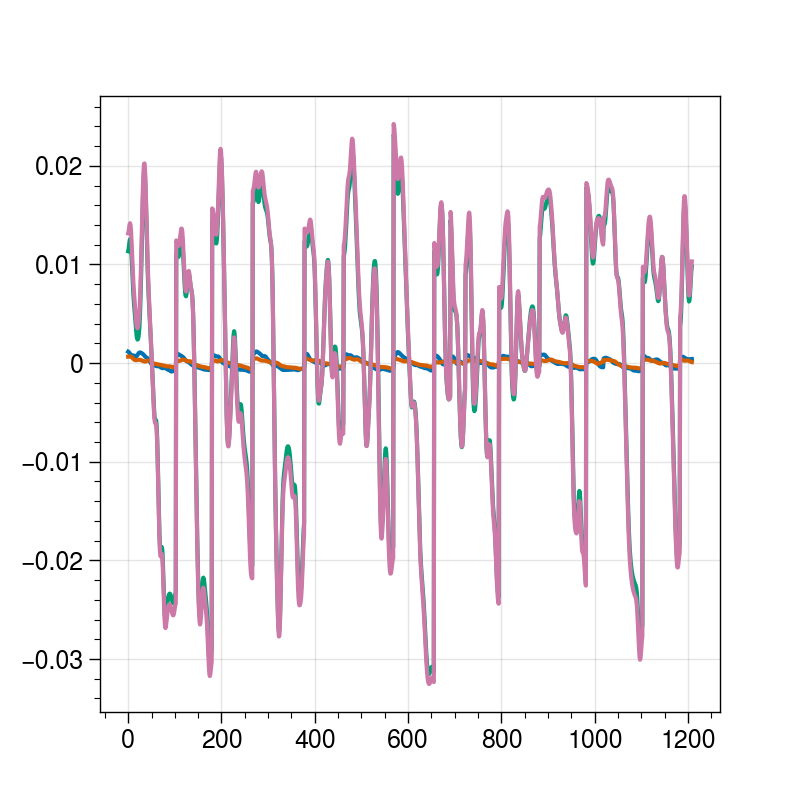

In [19]:
#AAAA = np.dot(Xtrain-np.nanmean(Xtrain,axis=0),PCAlw.components_.T)[:,0]+np.dot(Xtrain2-np.nanmean(Xtrain2,axis=0),PCAlw.components_.T)[:,0]+np.dot(Xtrain3-np.nanmean(Xtrain3,axis=0),PCAlw.components_.T)[:,0]
plt.plot(np.dot(Xtrain-np.nanmean(Xtrain,axis=0),PCAlw.components_.T)[:,0])
plt.plot(np.dot(Xtrain2-np.nanmean(Xtrain2,axis=0),PCAlw.components_.T)[:,0])
plt.plot(np.dot(Xtrain3-np.nanmean(Xtrain3,axis=0),PCAlw.components_.T)[:,0])
plt.plot(np.dot(Xtrain_orig-np.nanmean(Xtrain_orig,axis=0),PCAlw.components_.T)[:,0])
plt.show()

In [ ]:
for i in tqdm(range(41)):#41):
    trainsX,validsX,testsX = proc_inputoutput([int(so[i][0]),int(so[i][1])],[int(so[i][2]),int(so[i][3])],'./haiyan_store/pca/').create_X(vardicts_cp,nummem,varnames,i)
    trainsX_orig,_,_ = proc_inputoutput([int(so[i][0]),int(so[i][1])],[int(so[i][2]),int(so[i][3])],'./haiyan_store/pca/').create_X(vardicts,nummem,varnames,i)
    WSPD_train,WSPD_valid,WSPD_test = (preproc.train_valid_test(storeWSPD,[int(so[i][0]),int(so[i][1])],[int(so[i][2]),int(so[i][3])],'No'))
    wspdmean,wspdstd = np.nanmean(np.concatenate(WSPD_train)),np.nanstd(np.concatenate(WSPD_train))
    wspd_train,wspd_valid,wspd_test = np.concatenate([(obj-wspdmean)/wspdstd for obj in WSPD_train]),np.concatenate([(obj-wspdmean)/wspdstd for obj in WSPD_valid]),np.concatenate([(obj-wspdmean)/wspdstd for obj in WSPD_test])
    trainsX['intensity'] = wspd_train[:,np.newaxis]
    validsX['intensity'] = wspd_valid[:,np.newaxis]
    testsX['intensity']  = wspd_test[:,np.newaxis]
        
    storedict = {}
    for ind,EXP in enumerate(EXPS):
        storedict[storename[ind]] = {'train': np.concatenate([trainsX[varname] for varname in EXP], axis=1),'valid': np.concatenate([validsX[varname] for varname in EXP], axis=1),\
                                     'test': np.concatenate([testsX[varname] for varname in EXP], axis=1)}
    read_and_proc.save_to_pickle('./haiyan_store/X/'+str(i)+'/X_intensity.pkl',storedict,'PICKLE')
        
    y = {'train':[proc_inputoutput(so)._get_time_diff_ts(WSPD_train,60*60,int(LDTobj)) for LDTobj in np.linspace(0,35,36)+1],\
         'valid':[proc_inputoutput(so)._get_time_diff_ts(WSPD_valid,60*60,int(LDTobj)) for LDTobj in np.linspace(0,35,36)+1],\
         'test':[proc_inputoutput(so)._get_time_diff_ts(WSPD_test,60*60,int(LDTobj)) for LDTobj in np.linspace(0,35,36)+1]}
    outputY = {'train':[np.concatenate(yobj,axis=0) for yobj in y['train']],\
               'valid':[np.concatenate(yobj,axis=0) for yobj in y['valid']],\
               'test':[np.concatenate(yobj,axis=0) for yobj in y['test']]}
    read_and_proc.save_to_pickle('./haiyan_store/y/'+str(i)+'/y_intensity.pkl',outputY,'PICKLE')
        #np.concatenate([proc_inputoutput(so)._get_time_diff_ts(WSPD_valid,60*60,int(LDTobj)) for LDTobj in np.linspace(0,35,36)+1][23],axis=0).shape

In [8]:
if name=='MARIA':
    path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
    suffix = '_smooth_preproc_dict1b_g'

    maria_u = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix)['u'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
    maria_v = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix)['v'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
    maria_w = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix)['w'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
    maria_qv = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix)['qv'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
    maria_theta = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix)['theta'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
    maria_heatsum = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix)['heatsum'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
    maria_hdia = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix)['hdia'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
    maria_rad = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix)['rad'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
    maria_lw = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix+'_radcomp')['LW'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
    maria_sw = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix+'_radcomp')['SW'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]

    start = [find_start(maria_lw,0,1),find_start(maria_lw,0,2),find_start(maria_lw,0,3),find_start(maria_lw,0,4)]
    maria_ua,maria_va,maria_wa = long_MariaExps(maria_u,start),long_MariaExps(maria_v,start),long_MariaExps(maria_w,start)
    maria_qva,maria_thetaa,maria_heatsuma = long_MariaExps(maria_qv,start),long_MariaExps(maria_theta,start),long_MariaExps(maria_heatsum,start)
    maria_hdiaa,maria_swa,maria_lwa,maria_rada = long_MariaExps(maria_hdia,start),long_MariaExps(maria_sw,start),long_MariaExps(maria_lw,start),long_MariaExps(maria_rad,start)

    storeWSPD = []
    for i in range(len(maria_u)):
        storeWSPD.append(get_max_intensity(maria_ua[i],maria_va[i],[39,360,200]))
        
    sys.path.insert(1, '../')
    import read_stuff as read
    so_valid = [[2],[3],[4]]
    so_test = [[1],[1],[1]]
        
    #nummem=[50,38,91,28,8,82,20,20,20]
    nummem=[50,26,50,28,50,50,12,10,10]
    varnames = ['u', 'v', 'w', 'qv','theta', 'hdia', 'rad', 'lw', 'sw']
    EXPS = [['lw','sw'],['lw','sw','hdia'],['lw','sw','intensity'],['lw','sw','hdia','intensity'],['u','v','w','theta','hdia','lw','sw'],['u','v','w','theta','hdia','lw','sw','intensity']]
    storename = ['lwsw','lwswhdia','lwsw_inten','lwswhdia_inten','uvwthhdialwsw','uvwthhdialwsw_inten']
    vardicts = {'u':maria_ua,'v':maria_va,'w':maria_wa,'qv':maria_qva,'theta':maria_thetaa,'hdia':maria_hdiaa,'rad':maria_rada,'lw':maria_lwa,'sw':maria_swa}
    del maria_u, maria_v, maria_w, maria_qv, maria_theta, maria_hdia, maria_rad, maria_lw, maria_sw, maria_ua, maria_va, maria_wa, maria_qva, maria_thetaa, maria_hdiaa, maria_rada, maria_lwa, maria_swa
    gc.collect()
    for i in tqdm(range(3)):#41):
        trainsX,validsX,testsX = proc_inputoutput(so_valid[i],so_test[i],'./maria_store/pca/').create_X(vardicts,nummem,varnames,i)
        WSPD_train,WSPD_valid,WSPD_test = (preproc.train_valid_test(storeWSPD,so_valid[i],so_test[i],'No'))
        wspdmean,wspdstd = np.nanmean(np.concatenate(WSPD_train)),np.nanstd(np.concatenate(WSPD_train))
        wspd_train,wspd_valid,wspd_test = np.concatenate([(obj-wspdmean)/wspdstd for obj in WSPD_train]),np.concatenate([(obj-wspdmean)/wspdstd for obj in WSPD_valid]),np.concatenate([(obj-wspdmean)/wspdstd for obj in WSPD_test])
        trainsX['intensity'] = wspd_train[:,np.newaxis]
        validsX['intensity'] = wspd_valid[:,np.newaxis]
        testsX['intensity']  = wspd_test[:,np.newaxis]
        
        storedict = {}
        for ind,EXP in enumerate(EXPS):
            storedict[storename[ind]] = {'train': np.concatenate([trainsX[varname] for varname in EXP], axis=1),'valid': np.concatenate([validsX[varname] for varname in EXP], axis=1),\
                                         'test': np.concatenate([testsX[varname] for varname in EXP], axis=1)}
        read_and_proc.save_to_pickle('./maria_store/X/'+str(i)+'/X_corr.pkl',storedict,'PICKLE')
            
        WSPD_train,WSPD_valid,WSPD_test = (preproc.train_valid_test(storeWSPD,so_valid[i],so_test[i],'No'))
        y = {'train':[proc_inputoutput(so_valid[i],so_test[i],'./maria_store/pca/')._get_time_diff_ts(WSPD_train,60*60,int(LDTobj)) for LDTobj in np.linspace(0,35,36)+1],\
             'valid':[proc_inputoutput(so_valid[i],so_test[i],'./maria_store/pca/')._get_time_diff_ts(WSPD_valid,60*60,int(LDTobj)) for LDTobj in np.linspace(0,35,36)+1],\
             'test':[proc_inputoutput(so_valid[i],so_test[i],'./maria_store/pca/')._get_time_diff_ts(WSPD_test,60*60,int(LDTobj)) for LDTobj in np.linspace(0,35,36)+1]}
        outputY = {'train':[np.concatenate(yobj,axis=0) for yobj in y['train']],\
                   'valid':[np.concatenate(yobj,axis=0) for yobj in y['valid']],\
                   'test':[np.concatenate(yobj,axis=0) for yobj in y['test']]}
        read_and_proc.save_to_pickle('./maria_store/y/'+str(i)+'/y_corr.pkl',outputY,'PICKLE')
            #np.concatenate([proc_inputoutput(so)._get_time_diff_ts(WSPD_valid,60*60,int(LDTobj)) for LDTobj in np.linspace(0,35,36)+1][23],axis=0).shape

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
133+60+120

313

# indices

In [48]:
np.asarray([bobj for bobj in proc_inputoutput(so).train_valid_test([aobj[0] for aobj in a],0)][0]).cumsum()

array([ 103,  180,  267,  378,  462,  569,  656,  691,  723,  795,  882,
        982, 1019, 1103, 1183, 1209])

In [49]:
proc_inputoutput(so).train_valid_test([aobj[0] for aobj in a],0)

([103, 77, 87, 111, 84, 107, 87, 35, 32, 72, 87, 100, 37, 84, 80, 26],
 [67, 95],
 [106, 88])